# Loading the libraries 

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Spectral')
import missingno as msno

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Exploring the data

In [2]:
data = pd.read_csv(r'C:\Users\sogor\OneDrive\Documents\DataScientist_practice\datasets\Customer_Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print(f'Number of duplicated records in the data set: {data.duplicated().sum()}')

Number of duplicated records in the data set: 0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


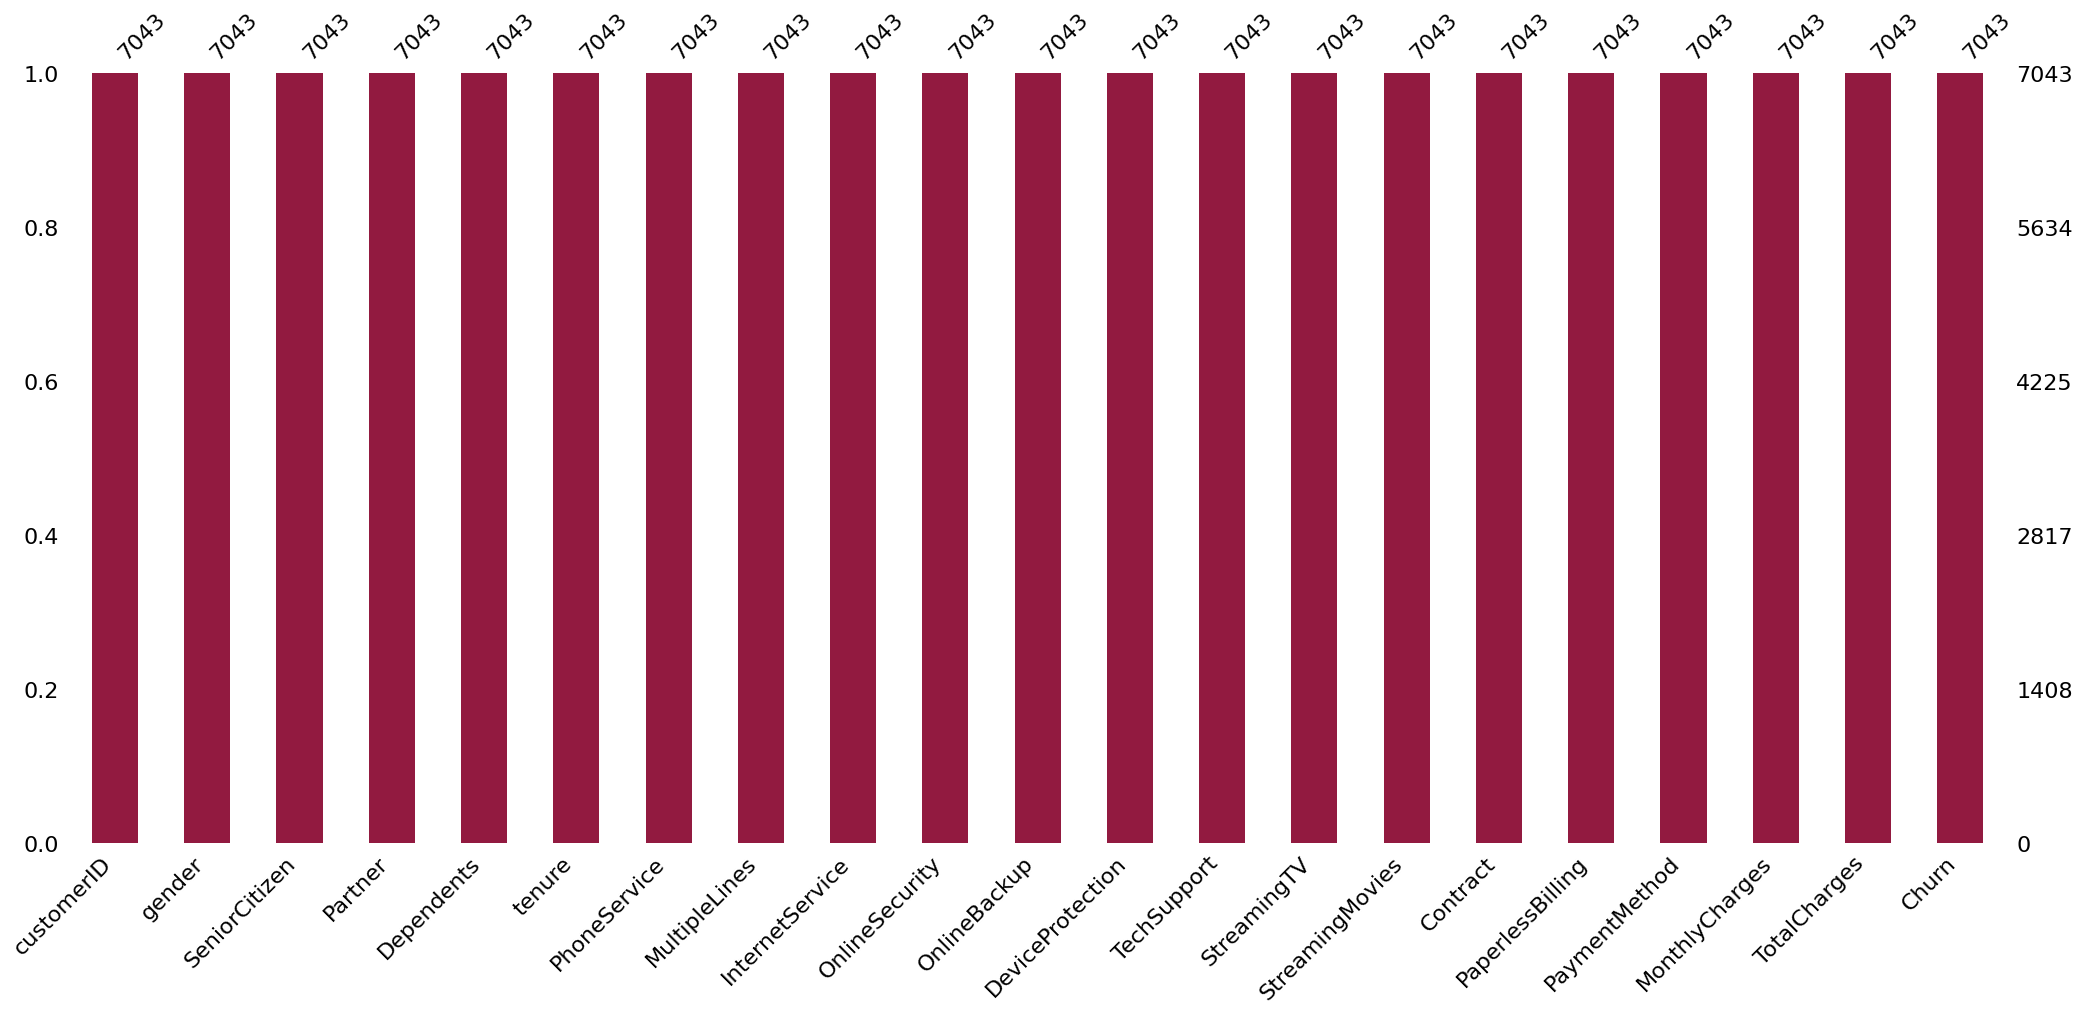

In [5]:
# Verification of missing values
msno.bar(data, color='#921A40')
plt.show()

# Preprocessing

In [6]:
# Removing CustomerId as it's unnecessary 
data.drop('customerID', axis=1, inplace=True)

In [7]:
# pivot_contract = data.pivot_table(index='Contract', columns='Churn', aggfunc='size', fill_value=0)
# pivot_contract['Churn Rate'] = pivot_contract[1] / (pivot_contract[0] + pivot_contract[1])
# pivot_contract

In [8]:
# Accessing the unique values in case of categorical features
{column: list(data[column].unique()) for column in data.columns if data.dtypes[column] == 'object'}

{'gender': ['Female', 'Male'],
 'Partner': ['Yes', 'No'],
 'Dependents': ['No', 'Yes'],
 'PhoneService': ['No', 'Yes'],
 'MultipleLines': ['No phone service', 'No', 'Yes'],
 'InternetService': ['DSL', 'Fiber optic', 'No'],
 'OnlineSecurity': ['No', 'Yes', 'No internet service'],
 'OnlineBackup': ['Yes', 'No', 'No internet service'],
 'DeviceProtection': ['No', 'Yes', 'No internet service'],
 'TechSupport': ['No', 'Yes', 'No internet service'],
 'StreamingTV': ['No', 'Yes', 'No internet service'],
 'StreamingMovies': ['No', 'Yes', 'No internet service'],
 'Contract': ['Month-to-month', 'One year', 'Two year'],
 'PaperlessBilling': ['Yes', 'No'],
 'PaymentMethod': ['Electronic check',
  'Mailed check',
  'Bank transfer (automatic)',
  'Credit card (automatic)'],
 'TotalCharges': ['29.85',
  '1889.5',
  '108.15',
  '1840.75',
  '151.65',
  '820.5',
  '1949.4',
  '301.9',
  '3046.05',
  '3487.95',
  '587.45',
  '326.8',
  '5681.1',
  '5036.3',
  '2686.05',
  '7895.15',
  '1022.95',
  '7382

In [9]:
# Converting TotalCharges into numerical
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.NaN)
data['TotalCharges'] = data['TotalCharges'].astype(float)
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].mean())

In [10]:
# >>>>>>>>>Some other preprocessing steps<<<<<<<<<<<<<<: 

# Replacing "No phone service" with "No"
data['MultipleLines'] = data['MultipleLines'].replace("No phone service", "No")

# Replacing "No internet service" with "No"
data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
      'TechSupport', 'StreamingTV', 'StreamingMovies']] = data[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                                                          'TechSupport', 'StreamingTV', 'StreamingMovies']].replace("No internet service", "No")

In [11]:
{column: list(data[column].unique()) for column in data.columns if data.dtypes[column] == 'object'}

{'gender': ['Female', 'Male'],
 'Partner': ['Yes', 'No'],
 'Dependents': ['No', 'Yes'],
 'PhoneService': ['No', 'Yes'],
 'MultipleLines': ['No', 'Yes'],
 'InternetService': ['DSL', 'Fiber optic', 'No'],
 'OnlineSecurity': ['No', 'Yes'],
 'OnlineBackup': ['Yes', 'No'],
 'DeviceProtection': ['No', 'Yes'],
 'TechSupport': ['No', 'Yes'],
 'StreamingTV': ['No', 'Yes'],
 'StreamingMovies': ['No', 'Yes'],
 'Contract': ['Month-to-month', 'One year', 'Two year'],
 'PaperlessBilling': ['Yes', 'No'],
 'PaymentMethod': ['Electronic check',
  'Mailed check',
  'Bank transfer (automatic)',
  'Credit card (automatic)'],
 'Churn': ['No', 'Yes']}

In [14]:
data.to_csv(r'C:/Users/sogor/OneDrive/Documents/DataScientist_practice/python/customer_churn_app/cleaned_churn.csv', index=False)

# Quick Visualization

In [ ]:
not_active_customers = data[data['Churn'] == 'Yes']
active_customers = data[data['Churn'] == 'No']

plt.figure(figsize=(10, 6))
plt.hist([not_active_customers['tenure'], active_customers['tenure']], bins=10, color=['#FF0000', '#387F39'], label=['Canceled their subscription', 'Remains subscribed'])
plt.title('Distribution of Tenure by Customer Churn')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.legend()

for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

In [ ]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=data)
plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('')
plt.ylabel('Monthly Charges')
plt.xticks(ticks=[0, 1], labels=['Remains subscribed', 'Canceled their subscription'])

plt.show()

In [ ]:
sns.kdeplot(data=data, x="TotalCharges", hue="Churn", fill=True, alpha=0.5)
plt.title('Density Plot of Total Charges by Churn Status')
plt.xlabel('Total Charges')
plt.ylabel('Density')

plt.show()

In [ ]:
for item in ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']:
    plt.figure(item, figsize=(6, 3))
    sns.countplot(data=data, x=data[item], hue='Churn')
    plt.title(item)
    plt.show()

In [ ]:
categorical_features = {
    'InternetService': data['InternetService'],
    'PaymentMethod': data['PaymentMethod'],
    'Contract': data['Contract']
}

fig, axes = plt.subplots(1, len(categorical_features), figsize=(12, 8))

if len(categorical_features) == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for ax, (feature, values) in zip(axes, categorical_features.items()):
    feature_churn_counts = data.groupby([feature, 'Churn']).size().unstack(fill_value=0)

    feature_churn_counts.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red'])
    
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.legend(title='Churn Status', labels=['Remains subscribed', 'Canceled their subscription'])
    
    ax.set_xticks(range(len(feature_churn_counts.index)))
    ax.set_xticklabels(feature_churn_counts.index, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Encoding 

In [ ]:
binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
nominal_features = 'PaymentMethod'
ordinal_features = ['InternetService', 'Contract'] 
target = 'Churn'


correct_internet_order = ['No', 'DSL', 'Fiber optic']
correct_contract_order = ['Month-to-month', 'One year', 'Two year']

In [ ]:
data['InternetService'].value_counts()

In [ ]:
def binary_encoder(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    
    return df

def ordinal_encoder(df, column, specified_order):
    df = df.copy()
    df[column] = df[column].apply(lambda x: specified_order.index(x))
    
    return df

def one_hot_encoder(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column])
    df = pd.concat([df, dummies], axis=1)
    df.drop(column, axis=1, inplace=True)
    
    return df

In [ ]:
data = binary_encoder(data, 'gender', 'Male')

for feature in binary_features[1:]:
    data = binary_encoder(data, feature, 'Yes') 
    
    
data = ordinal_encoder(data, ordinal_features[0], correct_internet_order)
data = ordinal_encoder(data, ordinal_features[1], correct_contract_order)

data = one_hot_encoder(data, nominal_features)

In [ ]:
data

In [ ]:
# Converting 'True'/'False' boolean values to numeric (1/0)
boolean_features = data.select_dtypes(include='bool')

for feature in boolean_features:
    data[feature] = data[feature].astype(int) 

In [ ]:
# Target column distribution 
data['Churn'].value_counts() 

In [ ]:
# Converting my target variable into numerical form 
data[target] = data[target].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
data

# Splitting/Scaling/Handling imbalance 

In [ ]:
# Definition of dependent and independent variables
y = data['Churn']
X = data.drop('Churn', axis=1)

In [ ]:
# Scaling down the values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Addressing the balance problem
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.7, random_state=42, stratify=y_resampled)

In [ ]:
print("Training set distribution after splitting:")
print(y_train.value_counts())

print("\nTesting set distribution:")
print(y_test.value_counts())

In [ ]:
X_train.shape, X_test.shape

# ANN building
**`Artificial Neural Networks (ANNs)`** are a subset of machine learning models inspired by the structure and function of the human brain. They consist of interconnected layers of nodes, or "neurons," which process and transform data through learned weights. NNs are particularly effective for complex tasks such as image recognition, natural language processing, and more.

**Key Terms:**

- `Neuron`: A neuron is a basic unit in an artificial neural network that receives input, applies a weight, sums up the input values, adds a bias, and then passes the result through an activation function.
- `Hidden Layer`: Hidden layers are intermediate layers between the input and output layers in a neural network. They perform transformations on the input data and extract features. The depth and number of hidden layers contribute to the network's ability to model complex functions.
- `Activation Function`:
    1. *relu*: It introduces non-linearity by allowing only positive values to pass through. It helps in overcoming the vanishing gradient problem and accelerates convergence.
    2. *sigmoid*: It maps input values to a range between 0 and 1, often used in binary classification problems.
    3. *softmax*: Used in multi-class classification, it converts logits into probabilities by exponentiating and normalizing them. It provides the probability distribution over multiple classes.
- `Optimizer==(Adam)`: Adam (Adaptive Moment Estimation) is an optimization algorithm that computes adaptive learning rates for each parameter. 
- `Mini Batch Gradient Descent`: This is an optimization technique where the model is trained using a subset of the training data (mini-batch in our case the batch size is 64) rather than the entire dataset at once. It helps in speeding up training and stabilizing convergence. Each mini-batch is used to compute the gradient and update the model weights.
- `tf.keras.callbacks.ReduceLROnPlateau()`: This callback monitors a specified metric (e.g., validation loss) during training. If the metric stops improving, it reduces the learning rate by a factor. This helps the model to converge more effectively by making smaller updates when it is closer to the optimal solution.
- `validation_split=0.2`: This parameter specifies the proportion of the training data to be used for validation. In this case, 20% of the training data is reserved for validation purposes to monitor the model's performance and detect overfitting.

In [ ]:
inputs = tf.keras.Input(shape=(22,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

batch_size = 32
epochs = 40 

history = model.fit(
    X_train,
    y_train, 
    validation_split = 0.2,
    batch_size = batch_size,
    epochs = epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0
)

In [ ]:
#Female,0,Yes,Yes,10,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),55.2,528.35,Yes

lst = np.array([1, 0, 0, 0, 11, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 97.85, 1105.4]).reshape(1, -1)
pred = model.predict(lst)

In [ ]:
pred[0][0]

# Reviewing the results

In [ ]:
plt.figure(figsize=(14, 10))

epochs_range = range(1, epochs + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs_range, train_loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_test_np = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

y_pred_prob = model.predict(X_test, batch_size=batch_size)

y_pred = (y_pred_prob > 0.5).astype(int)

y_test_flat = y_test_np.flatten()
y_pred_flat = y_pred.flatten()

report = classification_report(y_test_flat, y_pred_flat)
print("Classification Report:")
print(report)

In [ ]:
cm = confusion_matrix(y_test_flat, y_pred_flat)

cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Not Churned', 'Churned'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Remains subscribed', 'Canceled their subscription'], yticklabels=['Remains subscribed', 'Canceled their subscription'])
plt.title('Confusion Matrix of ANN', fontsize=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('Actual Label', fontsize=14)
plt.show()

# Cross Validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_auc_scores = []

X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

for train_index, val_index in kf.split(X_resampled):
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0
    )
    
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    
    accuracy = accuracy_score(y_val, y_pred)
    auc_score = roc_auc_score(y_val, model.predict(X_val))
    
    fold_accuracies.append(accuracy)
    fold_auc_scores.append(auc_score)

In [ ]:
print(f'Average Accuracy: {np.mean(fold_accuracies):.4f}')
print(f'Average AUC Score: {np.mean(fold_auc_scores):.4f}')

In [ ]:
# Saving the model for deployment   
import pickle

with open('C:/Users/sogor/OneDrive/Documents/DataScientist_practice/python/customer_churn_app/churn_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [ ]:
scaler2 = StandardScaler()
X_scaled = scaler2.fit_transform(X)

with open('C:/Users/sogor/OneDrive/Documents/DataScientist_practice/python/customer_churn_app/scaler.pkl', 'wb') as file:
    pickle.dump(scaler2, file)